In [139]:
from sunraster.instr.spice import read_spice_l2_fits
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from astropy.visualization import (AsinhStretch, ImageNormalize)
import eispac
import astropy.units as u
import astropy.constants as const
from astropy.visualization.wcsaxes import Quadrangle
import sunpy.map
from itertools import chain
from astropy.time import Time
from astropy.io import fits
from iris_spec_recon import iris_spec_map_interp_from_header
from scipy.io import readsav
from sunpy.coordinates import propagate_with_solar_surface
from corner import hist2d
import matplotlib.colors as mcolors

In [2]:
spice_l2_cube = read_spice_l2_fits('../../src/SPICE/20230330/solo_L2_spice-n-ras_20230330T104824_V03_184549532-004_coalign.fits')

Set MJD-OBS to 60033.450282 from DATE-OBS.
Set MJD-BEG to 60033.450282 from DATE-BEG.
Set MJD-AVG to 60033.483893 from DATE-AVG.
Set MJD-END to 60033.517501 from DATE-END'. [astropy.wcs.wcs]


In [3]:
spice_l2_cube.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'O II 718 - Peak (spectral bin 2)', 'O V 760 (Merged)', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'C III 977 - Peak', 'Ly Beta 1025 - Peak', 'O VI 1032 - Peak'])

In [4]:
spice_MgIX_window = spice_l2_cube['O III 703 / Mg IX 706 (Merged)']
spice_NeVIII_window = spice_l2_cube['Ne VIII 770 - Peak']
spice_NIV_window = spice_l2_cube['N IV 765 - Peak']
spice_CIII_window = spice_l2_cube['C III 977 - Peak']
spice_OVI_window = spice_l2_cube['O VI 1032 - Peak']

In [5]:
spice_NeVIII_window.meta['DATE-BEG'], spice_NeVIII_window.meta['DATE-END']

('2023-03-30T10:48:24.362', '2023-03-30T12:25:12.123')

In [6]:
spice_NeVIII_window.meta['HGLN_OBS'], spice_NeVIII_window.meta['HGLT_OBS']

(5.44798395469, -7.98833249343)

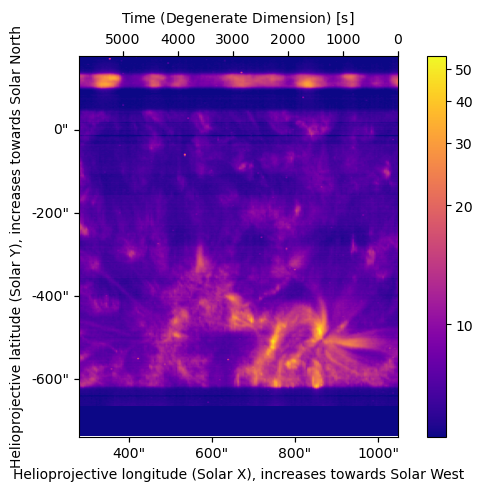

In [7]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_NeVIII_window.wcs[0,0,:,:])    
im = ax.imshow(np.nansum(spice_NeVIII_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NeVIII_window.meta['CDELT2']/spice_NeVIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,stretch=AsinhStretch()))
plt.colorbar(im)

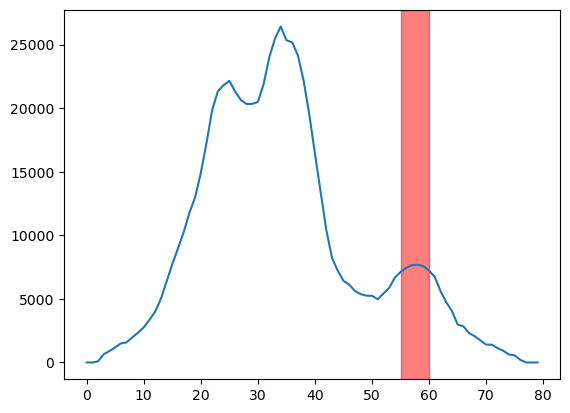

In [8]:
plt.plot(np.nansum(spice_MgIX_window.data,axis=(0,2,3)))
plt.axvspan(55, 60, color='red', alpha=0.5)

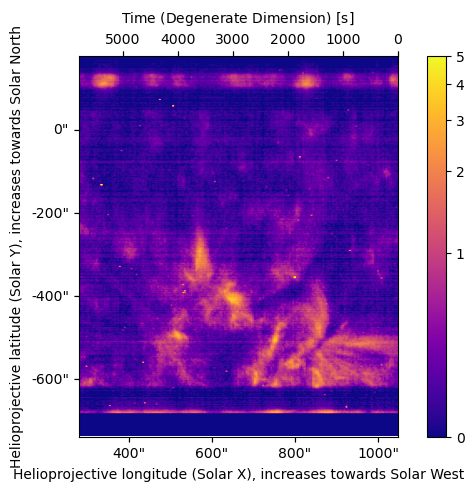

In [9]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_MgIX_window.wcs[0,0,:,:])    
im = ax.imshow(np.nansum(spice_MgIX_window.data[:,55:61,:,:],axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_MgIX_window.meta['CDELT2']/spice_MgIX_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=0,vmax=5,stretch=AsinhStretch()))
plt.colorbar(im)

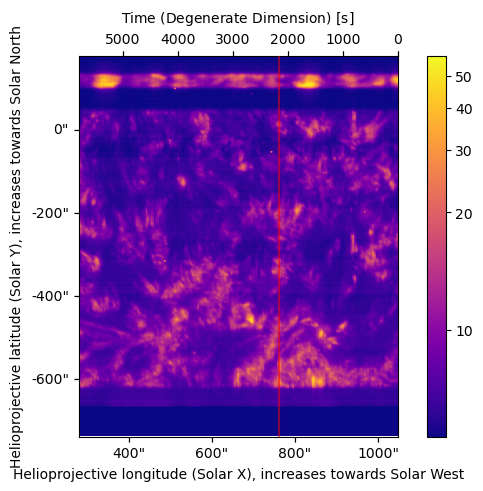

In [10]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_NIV_window.wcs[0,0,:,:])
im = ax.imshow(np.nansum(spice_NIV_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,stretch=AsinhStretch()))
plt.colorbar(im)
ax.axvline(120, color='red', alpha=0.5)

2023-03-30T11:24:27.112


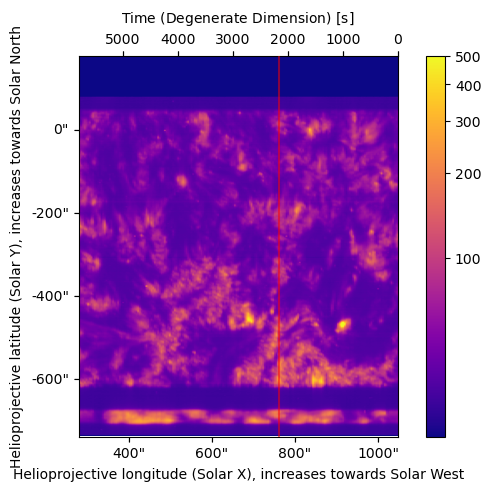

In [11]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_CIII_window.wcs[0,0,:,:])
im = ax.imshow(np.nansum(spice_CIII_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,vmax=500,stretch=AsinhStretch()))
plt.colorbar(im)
ax.axvline(120, color='red', alpha=0.5)
print(spice_CIII_window.wcs[:,0,:,:].pixel_to_world(120,0,0)[1].isot)

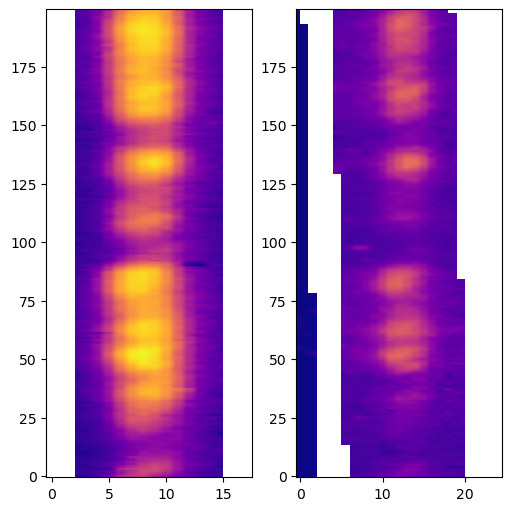

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,5),layout='constrained')

ax1.imshow(spice_CIII_window.data[0,:,300:500,120].T, origin='lower', cmap='plasma',aspect='auto',
           norm=ImageNormalize(stretch=AsinhStretch()))

ax2.imshow(spice_NIV_window.data[0,:,300:500,120].T, origin='lower', cmap='plasma',aspect='auto',
              norm=ImageNormalize(vmin=0.2,vmax=6,stretch=AsinhStretch()))

In [13]:
spice_CIII_window.data.shape

(1, 18, 834, 192)

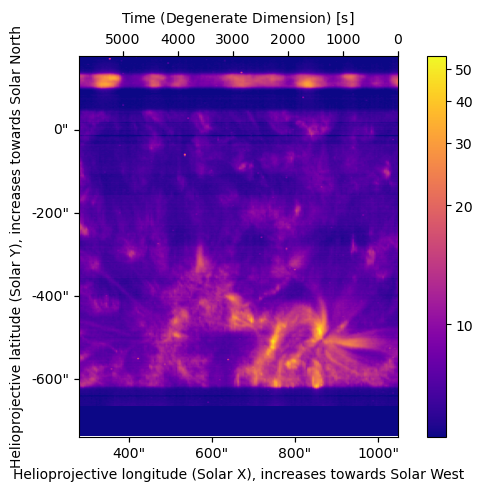

In [14]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_NeVIII_window.wcs[0,0,:,:])    
im = ax.imshow(np.nansum(spice_NeVIII_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NeVIII_window.meta['CDELT2']/spice_NeVIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,stretch=AsinhStretch()))
plt.colorbar(im)

In [15]:
eis_fitres_FeXII_195 = eispac.read_fit('../../src/EIS/20230330T1203/eis_20230330_120319.fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap = eis_fitres_FeXII_195.get_map(component=0, measurement='intensity')
#override date_avg to date_obs to get the correct date for WCS
eis_FeXII_195_intmap.meta['date_avg'] = eis_FeXII_195_intmap.meta['date_obs']
eis_FeXII_195_velmap = eis_fitres_FeXII_195.get_map(component=0, measurement='velocity')
eis_FeXII_195_velmap.meta['date_avg'] = eis_FeXII_195_velmap.meta['date_obs']

Reading fit result from, 
   ../../src/EIS/20230330T1203/eis_20230330_120319.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


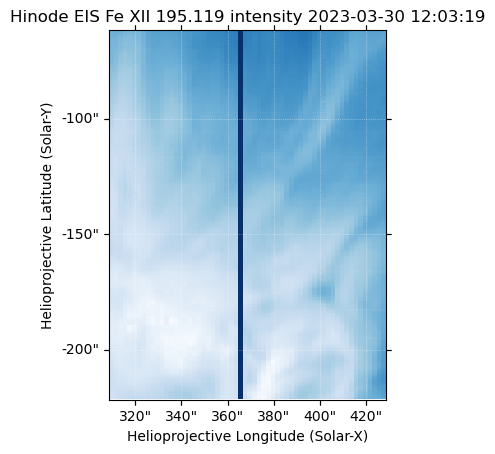

In [16]:
eis_FeXII_195_intmap.plot()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


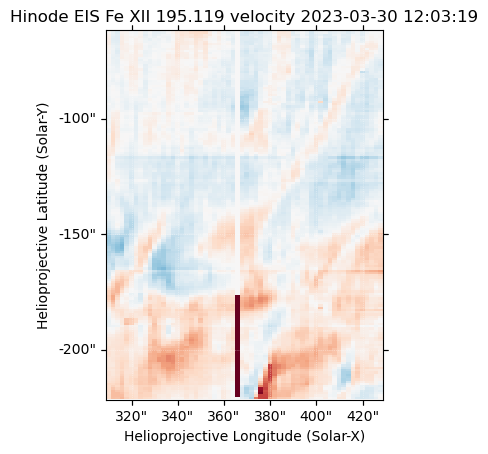

In [17]:
eis_FeXII_195_velmap.plot(norm=ImageNormalize(vmin=-20,vmax=20))

In [18]:
eis_fitres_FeVIII_185 = eispac.read_fit('../../src/EIS/20230330T1203/eis_20230330_120319.fe_08_185_213.1c-0.fit.h5')
eis_FeVIII_185_intmap = eis_fitres_FeVIII_185.get_map(component=0, measurement='intensity')
#override date_avg to date_obs to get the correct date for WCS
eis_FeVIII_185_intmap.meta['date_avg'] = eis_FeVIII_185_intmap.meta['date_obs']
eis_FeVIII_185_velmap = eis_fitres_FeVIII_185.get_map(component=0, measurement='velocity')
eis_FeVIII_185_velmap.meta['date_avg'] = eis_FeVIII_185_velmap.meta['date_obs']

Reading fit result from, 
   ../../src/EIS/20230330T1203/eis_20230330_120319.fe_08_185_213.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


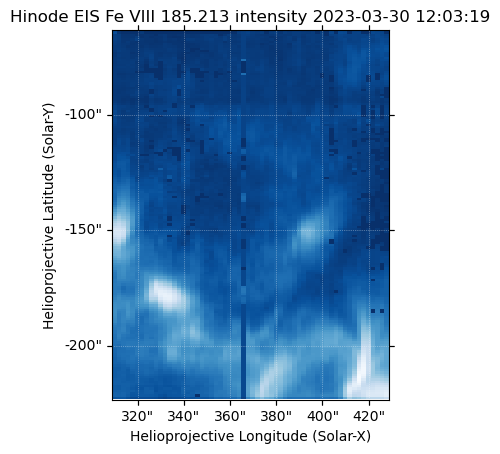

In [19]:
eis_FeVIII_185_intmap.plot()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


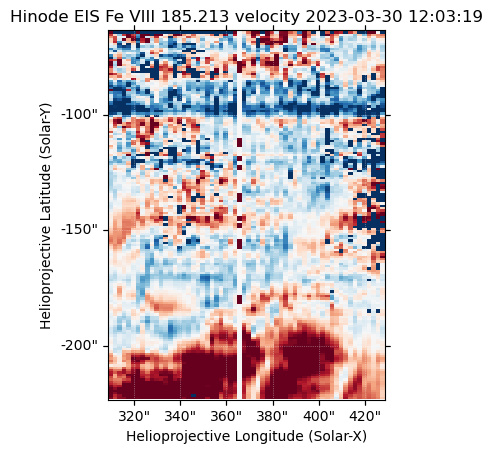

In [20]:
eis_FeVIII_185_velmap.plot(norm=ImageNormalize(vmin=-20,vmax=20))

In [21]:
eis_fitres_FeIX_197 = eispac.read_fit('../../src/EIS/20230330T1203/eis_20230330_120319.fe_09_197_862.1c-0.fit.h5')
eis_FeIX_197_intmap = eis_fitres_FeIX_197.get_map(component=0, measurement='intensity')
#override date_avg to date_obs to get the correct date for WCS
eis_FeIX_197_intmap.meta['date_avg'] = eis_FeIX_197_intmap.meta['date_obs']
eis_FeIX_197_velmap = eis_fitres_FeIX_197.get_map(component=0, measurement='velocity')
eis_FeIX_197_velmap.meta['date_avg'] = eis_FeIX_197_velmap.meta['date_obs']

Reading fit result from, 
   ../../src/EIS/20230330T1203/eis_20230330_120319.fe_09_197_862.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


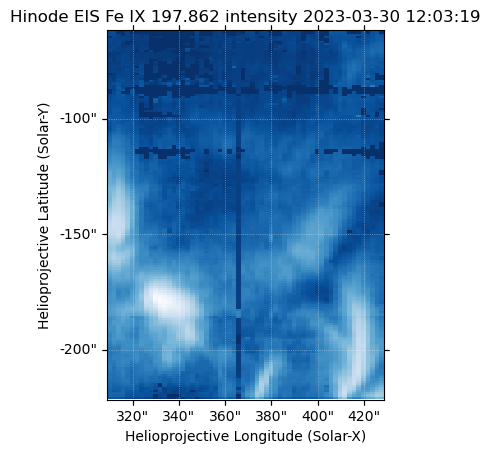

In [22]:
eis_FeIX_197_intmap.plot()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


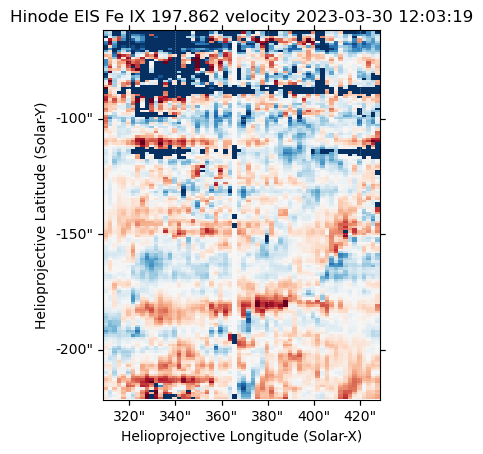

In [23]:
eis_FeIX_197_velmap.plot(norm=ImageNormalize(vmin=-20,vmax=20))

In [24]:
eis_fitres_FeX_184 = eispac.read_fit('../../src/EIS/20230330T1203/eis_20230330_120319.fe_10_184_536.1c-0.fit.h5')
eis_FeX_184_intmap = eis_fitres_FeX_184.get_map(component=0, measurement='intensity')
#override date_avg to date_obs to get the correct date for WCS
eis_FeX_184_intmap.meta['date_avg'] = eis_FeX_184_intmap.meta['date_obs']
eis_FeX_184_velmap = eis_fitres_FeX_184.get_map(component=0, measurement='velocity')
eis_FeX_184_velmap.meta['date_avg'] = eis_FeX_184_velmap.meta['date_obs']

Reading fit result from, 
   ../../src/EIS/20230330T1203/eis_20230330_120319.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


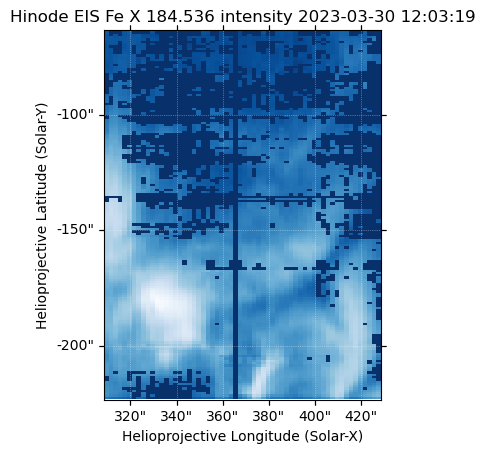

In [25]:
eis_FeX_184_intmap.plot()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


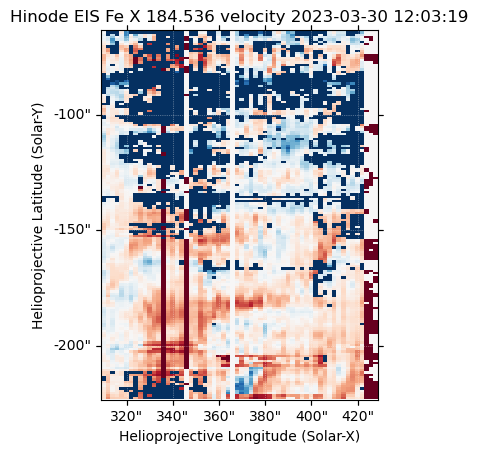

In [26]:
eis_FeX_184_velmap.plot(norm=ImageNormalize(vmin=-20,vmax=20))

In [27]:
def get_map_edge_coords(map, step=1):
    map_edges = sunpy.map.map_edges(map)

    x_pix = []
    y_pix = []

    if map_edges[1].shape[0] % step != 0:
        iter_1 = chain(range(0, map_edges[1].shape[0], step), [map_edges[1].shape[0]-1])
    else:
        iter_1 = range(0, map_edges[1].shape[0], step)
    for ii in iter_1:
        x_pix.append(map_edges[1][ii,0].value)
        y_pix.append(map_edges[1][ii,1].value)

    if map_edges[3].shape[0] % step != 0:
        iter_3 = chain(range(0, map_edges[3].shape[0], step), [map_edges[3].shape[0]-1])
    else:
        iter_3 = range(0, map_edges[3].shape[0], step)

    for ii in iter_3:
        x_pix.append(map_edges[3][ii,0].value)
        y_pix.append(map_edges[3][ii,1].value)

    if map_edges[0].shape[0] % step != 0:
        iter_0 = chain(range(map_edges[0].shape[0]-1, -1, -step), [0])
    else:
        iter_0 = range(map_edges[0].shape[0]-1, -1, -step)

    for ii in iter_0:
        x_pix.append(map_edges[0][ii,0].value)
        y_pix.append(map_edges[0][ii,1].value)

    if map_edges[2].shape[0] % step != 0:
        iter_2 = chain(range(map_edges[2].shape[0]-1, -1, -step), [0])
    else:
        iter_2 = range(map_edges[2].shape[0]-1, -1, -step)

    for ii in iter_2:
        x_pix.append(map_edges[2][ii,0].value)
        y_pix.append(map_edges[2][ii,1].value)
    
    return map.pixel_to_world(x_pix*u.pix,y_pix*u.pix)

In [28]:
eis_FeXII_195_velmap_edges = get_map_edge_coords(eis_FeXII_195_velmap,step=5)

In [29]:
eis_FeXII_195_velmap_edges_with_time = [eis_FeXII_195_velmap_edges, Time([eis_FeXII_195_velmap_edges.obstime]*eis_FeXII_195_velmap_edges.shape[0])]

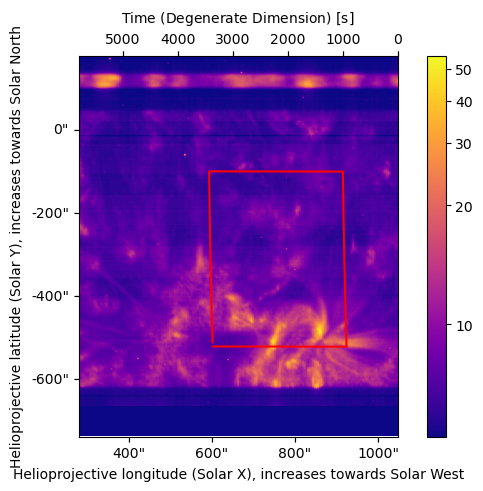

In [30]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_NeVIII_window.wcs[0,0,:,:])    
im = ax.imshow(np.nansum(spice_NeVIII_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NeVIII_window.meta['CDELT2']/spice_NeVIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,stretch=AsinhStretch()))
plt.colorbar(im)
ax.plot(*spice_NeVIII_window.wcs[0,0,:,:].world_to_pixel(*eis_FeXII_195_velmap_edges_with_time),
           color='red', lw=1.5)

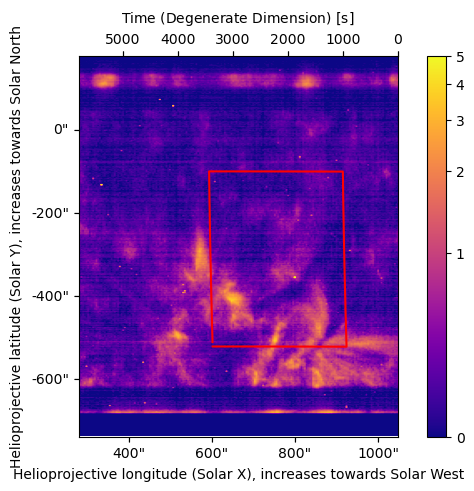

In [31]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_MgIX_window.wcs[0,0,:,:])    
im = ax.imshow(np.nansum(spice_MgIX_window.data[:,55:61,:,:],axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_MgIX_window.meta['CDELT2']/spice_MgIX_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=0,vmax=5,stretch=AsinhStretch()))
plt.colorbar(im)
ax.plot(*spice_NeVIII_window.wcs[0,0,:,:].world_to_pixel(*eis_FeXII_195_velmap_edges_with_time),
           color='red', lw=1.5)

In [32]:
raster_header_0 = fits.getheader("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",ext=0)
raster_header_SiIV = fits.getheader("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",ext=3)
raster_data_SiIV = fits.getdata("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",ext=3)
raster_data_SiIV = np.flip(raster_data_SiIV,axis=0)
raster_data_SiIV = raster_data_SiIV.reshape((raster_data_SiIV.shape[0],-1,2,raster_data_SiIV.shape[2]))
raster_data_SiIV = np.nanmean(raster_data_SiIV,axis=(2))
raster_data_SiIV = raster_data_SiIV.reshape((-1,2,raster_data_SiIV.shape[1],raster_data_SiIV.shape[2]))
raster_data_SiIV = np.nanmean(raster_data_SiIV,axis=(1))

In [33]:
SiIV_1393_fitres_file = readsav("../../src/IRIS/20230330/fit_res/SiIV_1393_raster0_rebin.sav",verbose=True)

--------------------------------------------------
Date: Mon Aug  5 17:41:45 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 12 records of which:
 - 9 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - int [<class 'numpy.ndarray'>]
 - int_err [<class 'numpy.ndarray'>]
 - vel [<class 'numpy.ndarray'>]
 - vel_err [<class 'numpy.ndarray'>]
 - wid [<class 'numpy.ndarray'>]
 - wid_err [<class 'numpy.ndarray'>]
 - chi2 [<class 'numpy.ndarray'>]
 - refwvl [<class 'numpy.ndarray'>]
 - wave_corr_fuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [34]:
SiIV_1393_mask = (np.abs(SiIV_1393_fitres_file["wid_err"]/SiIV_1393_fitres_file["wid"]) > 0.5) | \
                (SiIV_1393_fitres_file["wid"] < 0.04) | \
                (np.abs(SiIV_1393_fitres_file["int_err"]/SiIV_1393_fitres_file["int"]) > 0.5) | \
                (np.abs(SiIV_1393_fitres_file["vel_err"]) > 10 )

In [35]:
import iris_spec_recon
import importlib
importlib.reload(iris_spec_recon)
from iris_spec_recon import iris_spec_map_interp_from_header

In [36]:
SiIV_1393_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",
                    win_ext=3,data=SiIV_1393_fitres_file["int"].copy(),xbin=2,ybin=2)
SiIV_1393_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",
                    win_ext=3,data=SiIV_1393_fitres_file["vel"].copy(),mask=SiIV_1393_mask,xbin=2,ybin=2)

/tmp/ipykernel_981377/2718043524.py:1: UserWarning: Negative CDELT3 found (raster from west to east). Changing sign to positive. Because we assume `iris_auto_fit` has flipped the data, we will not flip it back.
  SiIV_1393_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",
/tmp/ipykernel_981377/2718043524.py:3: UserWarning: Negative CDELT3 found (raster from west to east). Changing sign to positive. Because we assume `iris_auto_fit` has flipped the data, we will not flip it back.
  SiIV_1393_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20230330/iris_l2_20230330_090346_3400109477_raster_t000_r00003.fits",


In [37]:
SiIV_1393_vel_map_norm = sunpy.map.Map(SiIV_1393_vel_map.data - np.nanmedian(SiIV_1393_vel_map.data), SiIV_1393_vel_map.meta)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


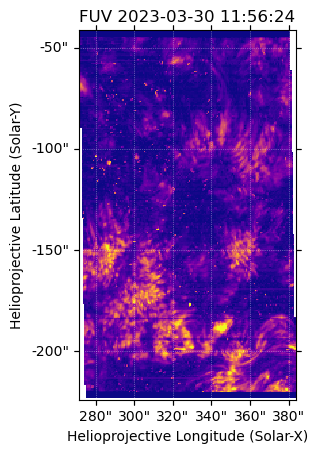

In [38]:
SiIV_1393_int_map.plot(norm=ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch()),cmap='plasma')

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


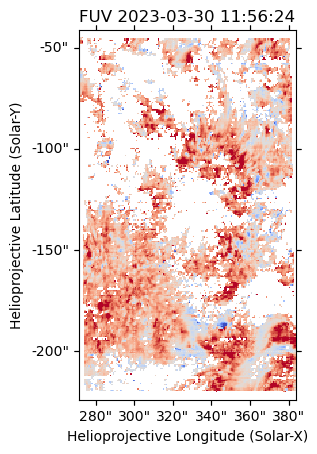

In [39]:
SiIV_1393_vel_map.plot(norm=ImageNormalize(vmin=-20,vmax=20),cmap='coolwarm')

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


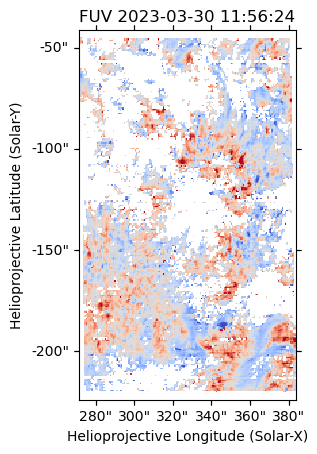

In [40]:
SiIV_1393_vel_map_norm.plot(norm=ImageNormalize(vmin=-20,vmax=20),cmap='coolwarm')

In [41]:
SiIV_1393_int_map_edges = get_map_edge_coords(SiIV_1393_int_map,step=5)
SiIV_1393_int_map_edges_with_time = [SiIV_1393_int_map_edges, Time([SiIV_1393_int_map_edges.obstime]*SiIV_1393_int_map_edges.shape[0])]

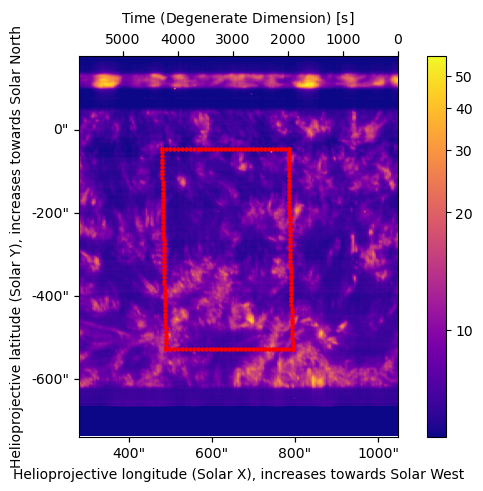

In [42]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_NIV_window.wcs[0,0,:,:])
im = ax.imshow(np.nansum(spice_NIV_window.data,axis=(0,1)), origin='lower', cmap='plasma',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=5,stretch=AsinhStretch()))
plt.colorbar(im)
with propagate_with_solar_surface(rotation_model='rigid'):
    ax.scatter(*spice_NIV_window.wcs[0,0,:,:].world_to_pixel(*SiIV_1393_int_map_edges_with_time),color='red',s=5)

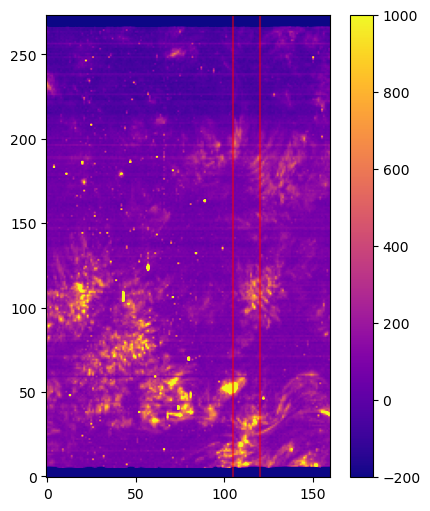

In [43]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')

im = ax.imshow(np.nansum(raster_data_SiIV[:,:,75:125],axis=-1).T, origin='lower', cmap='plasma', 
          aspect=-raster_header_SiIV['CDELT2']/raster_header_SiIV['CDELT3'],
          vmin=-200,vmax=1e3)
plt.colorbar(im)
ax.axvline(120, color='red', alpha=0.5)
ax.axvline(105, color='red', alpha=0.5)

In [44]:
raster_header_0['DATE_OBS'], raster_header_0['DATE_END']

('2023-03-30T11:31:48.640', '2023-03-30T12:20:59.430')

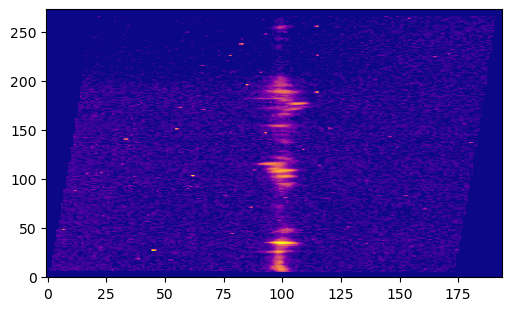

In [46]:
fig, ax = plt.subplots(figsize=(5,3),layout='constrained')

im = ax.imshow(raster_data_SiIV[120,:,:], origin='lower', cmap='plasma',
               aspect='auto',
                norm=ImageNormalize(vmin=0,vmax=1e2,stretch=AsinhStretch()))

In [80]:
with fits.open("../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/"
               "solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00765.15-n_4_con-00_time-240805T190026.fits") as hdul:
    hdul.info()

Filename: ../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00765.15-n_4_con-00_time-240805T190026.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (192, 834)   float64   
  1                1 ImageHDU        68   (192, 834)   float64   
  2                1 ImageHDU        68   (192, 834)   float64   
  3                1 ImageHDU        68   (192, 834)   float64   
  4                1 ImageHDU        68   (192, 834)   float64   
  5                1 ImageHDU        68   (192, 834)   float64   


In [81]:
saffron_spice_NIV_int = fits.getdata("../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/"
                                     "solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00765.15-n_4_con-00_time-240805T190026.fits",ext=0)
saffron_spice_NIV_vel = fits.getdata("../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/"
                                        "solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00765.15-n_4_con-00_time-240805T190026.fits",ext=1)
saffron_spice_NIV_vel = saffron_spice_NIV_vel/765.15*const.c.to(u.km/u.s).value
saffron_spice_NIV_vel = saffron_spice_NIV_vel - np.nanmedian(saffron_spice_NIV_vel)

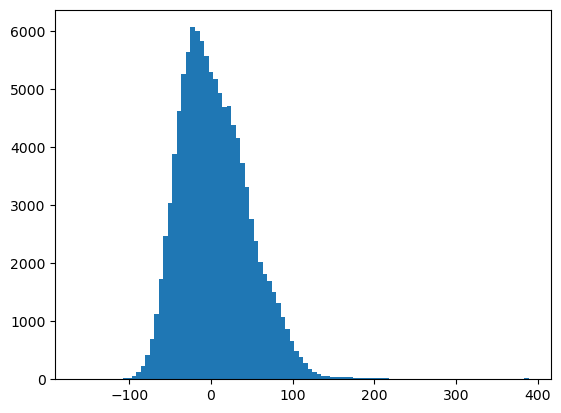

In [63]:
_ = plt.hist(saffron_spice_NIV_vel.flatten(),bins=100)

/tmp/ipykernel_981377/2560048087.py:1: RuntimeWarning: All-NaN slice encountered
  plt.plot(np.nanmedian(saffron_spice_NIV_vel,axis=1))


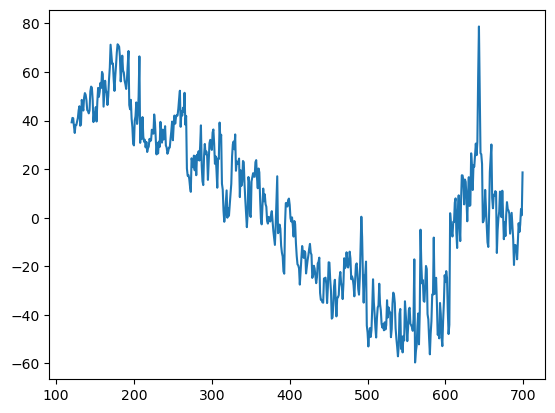

In [82]:
plt.plot(np.nanmedian(saffron_spice_NIV_vel,axis=1))

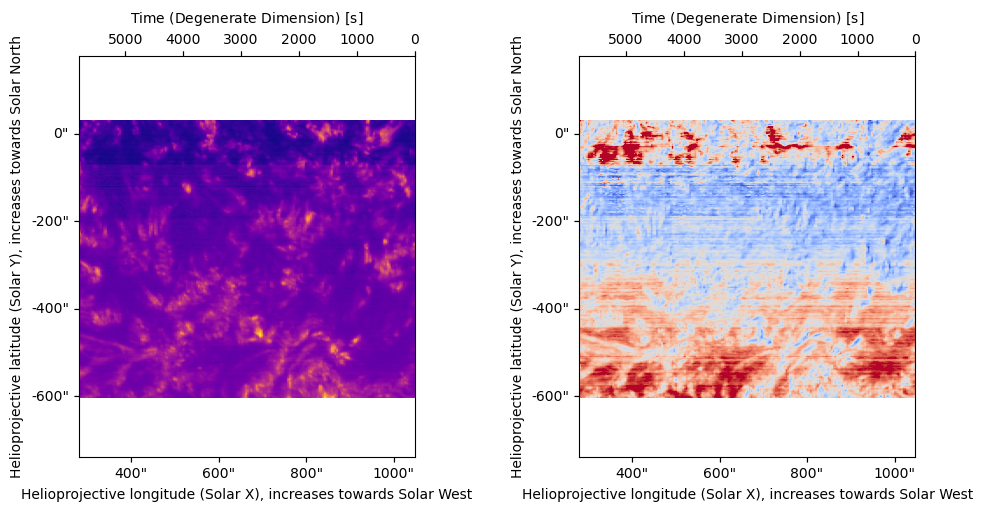

In [62]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=spice_NIV_window.wcs[0,0,:,:])
im1 = ax1.imshow(saffron_spice_NIV_int, origin='lower', cmap='plasma',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(stretch=AsinhStretch()))

ax2 = fig.add_subplot(122,projection=spice_NIV_window.wcs[0,0,:,:])
im2 = ax2.imshow(saffron_spice_NIV_vel, origin='lower', cmap='coolwarm',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=-100,vmax=100))

/tmp/ipykernel_981377/4267331497.py:8: RuntimeWarning: All-NaN slice encountered
  im2 = ax2.imshow(saffron_spice_NIV_vel - np.nanmedian(saffron_spice_NIV_vel, axis=1)[:,np.newaxis], origin='lower', cmap='coolwarm',


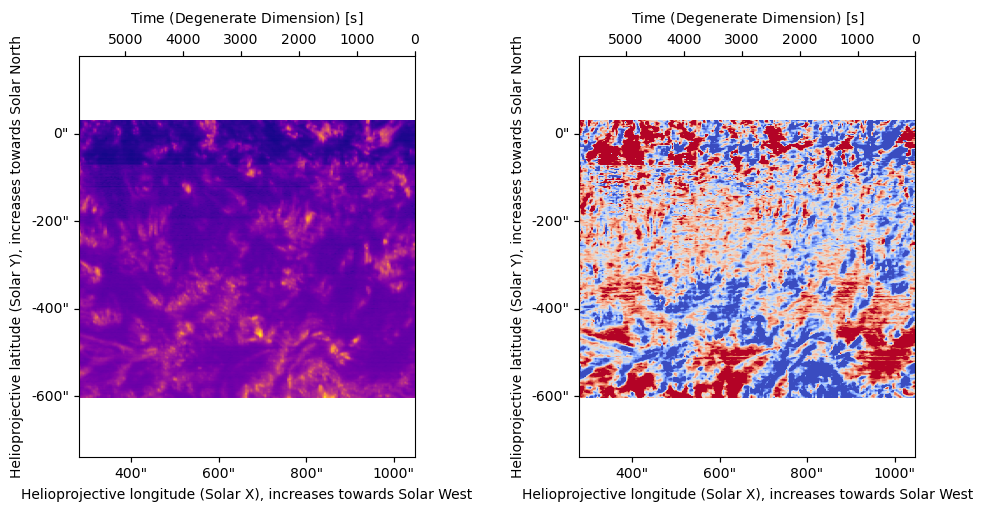

In [156]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=spice_NIV_window.wcs[0,0,:,:])
im1 = ax1.imshow(saffron_spice_NIV_int, origin='lower', cmap='plasma',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(stretch=AsinhStretch()))

ax2 = fig.add_subplot(122,projection=spice_NIV_window.wcs[0,0,:,:])
im2 = ax2.imshow(saffron_spice_NIV_vel - np.nanmedian(saffron_spice_NIV_vel, axis=1)[:,np.newaxis], origin='lower', cmap='coolwarm',
          aspect=spice_NIV_window.meta['CDELT2']/spice_NIV_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=-30,vmax=30))

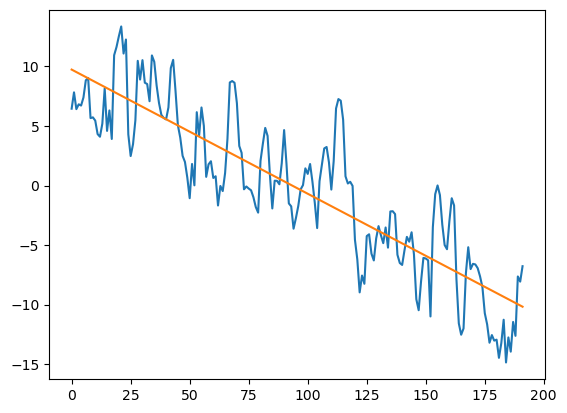

In [145]:
saffron_spice_CIII_int = fits.getdata("../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/"
                                      "solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00977.03-c_3_con-00_time-240805T190026.fits",
                                        ext=0)
saffron_spice_CIII_vel = fits.getdata("../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20230330T104824_V03_18454953/con-00/"
                                        "solo_L2.5_spice-n-ras_20230330T104824_V03_18454953_00977.03-c_3_con-00_time-240805T190026.fits",
                                         ext=1)
saffron_spice_CIII_vel = saffron_spice_CIII_vel/977.03*const.c.to(u.km/u.s).value
saffron_spice_CIII_vel = saffron_spice_CIII_vel - np.nanmedian(saffron_spice_CIII_vel)
saffron_spice_CIII_vel_masked = ma.masked_array(saffron_spice_CIII_vel, mask=(saffron_spice_CIII_int < 2) | (~np.isfinite(saffron_spice_CIII_vel)))
saffron_spice_CIII_vel_masked = saffron_spice_CIII_vel_masked - np.ma.median(saffron_spice_CIII_vel_masked)
saffron_spice_CIII_vel_grad_fit_params = np.polyfit(np.arange(saffron_spice_CIII_vel_masked.shape[1]),saffron_spice_CIII_vel_masked.mean(axis=0),1)

saffron_spice_CIII_vel_grad_fit_func = np.poly1d(saffron_spice_CIII_vel_grad_fit_params)
plt.plot(saffron_spice_CIII_vel_masked.mean(axis=0))
plt.plot(saffron_spice_CIII_vel_grad_fit_func(np.arange(saffron_spice_CIII_vel_masked.shape[1])))
saffron_spice_CIII_vel_masked = saffron_spice_CIII_vel_masked - saffron_spice_CIII_vel_grad_fit_func(np.arange(saffron_spice_CIII_vel_masked.shape[1]))[np.newaxis,:]

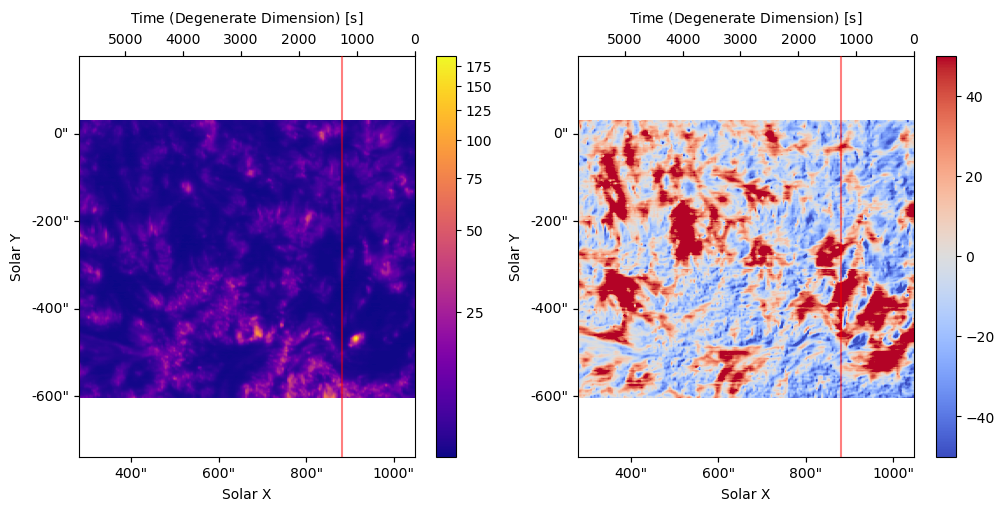

In [146]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=spice_CIII_window.wcs[0,0,:,:])
im1 = ax1.imshow(saffron_spice_CIII_int, origin='lower', cmap='plasma',
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar(im1)

ax2 = fig.add_subplot(122,projection=spice_CIII_window.wcs[0,0,:,:])
im2 = ax2.imshow(saffron_spice_CIII_vel, origin='lower', cmap='coolwarm',
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=-50,vmax=50))
plt.colorbar(im2)

for ax in [ax1,ax2]:
    ax.set_xlabel('Solar X')
    ax.set_ylabel('Solar Y')
    ax.axvline(150, color='red', alpha=0.5)

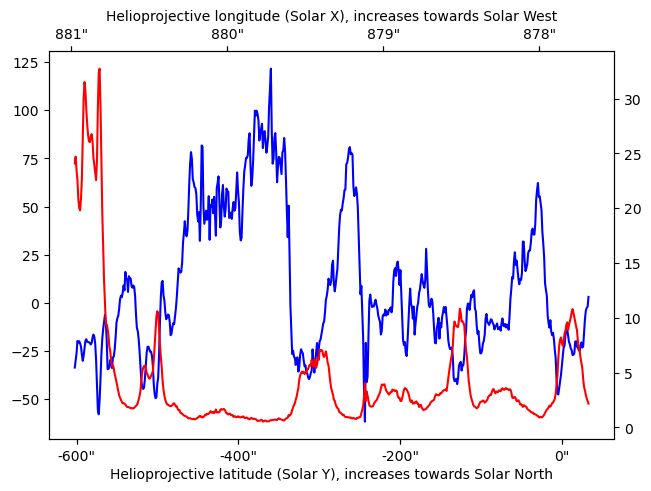

In [155]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=spice_CIII_window.wcs[0,0,:,150])
ax.plot(saffron_spice_CIII_vel[:,150],color='blue')
ax_int = ax.twinx()
ax_int.plot(saffron_spice_CIII_int[:,150],color='red')

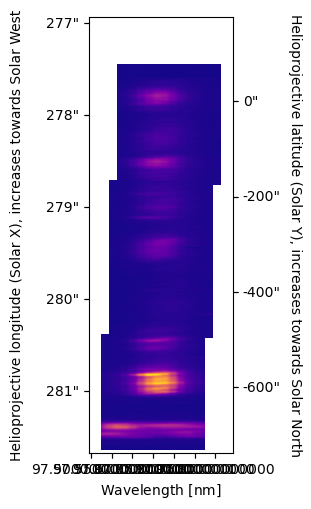

In [147]:
fig = plt.figure(figsize=(3,5),layout='constrained')
ax = fig.add_subplot(projection=spice_CIII_window.wcs,slices=(0,'y','x',150))
ax.imshow(spice_CIII_window.data[0,:,:,150].T, origin='lower', cmap='plasma',aspect='auto',)
ax.coords[2].set_format_unit(u.nm)

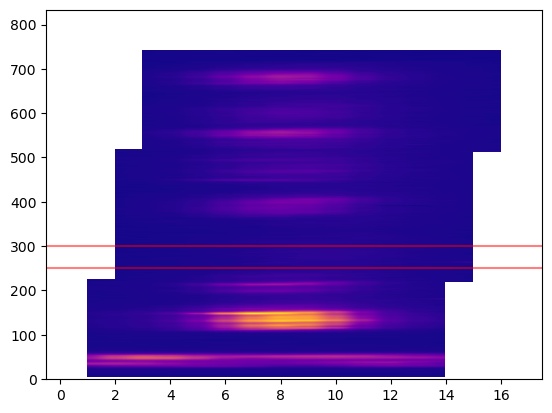

In [148]:
plt.imshow(spice_CIII_window.data[0,:,:,150].T, origin='lower', cmap='plasma',aspect='auto',)
plt.axhline(250, color='red', alpha=0.5)
plt.axhline(300, color='red', alpha=0.5)

/tmp/ipykernel_981377/601504453.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(spice_CIII_window.data[0,:,250:300,150],axis=-1))


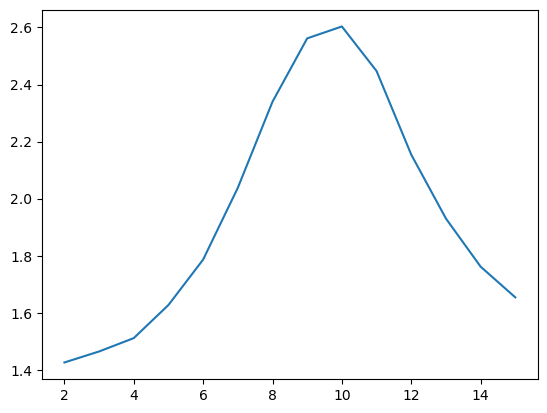

In [149]:
plt.plot(np.nanmean(spice_CIII_window.data[0,:,250:300,150],axis=-1))

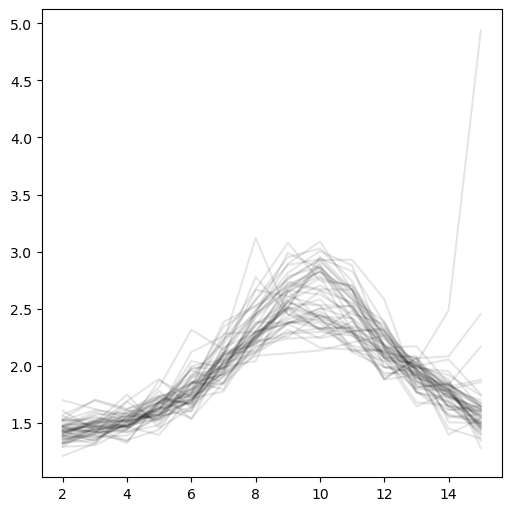

In [150]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')
for ii in range(250,300):
    ax.plot(spice_CIII_window.data[0,:,ii,150], color='black', alpha=0.1)

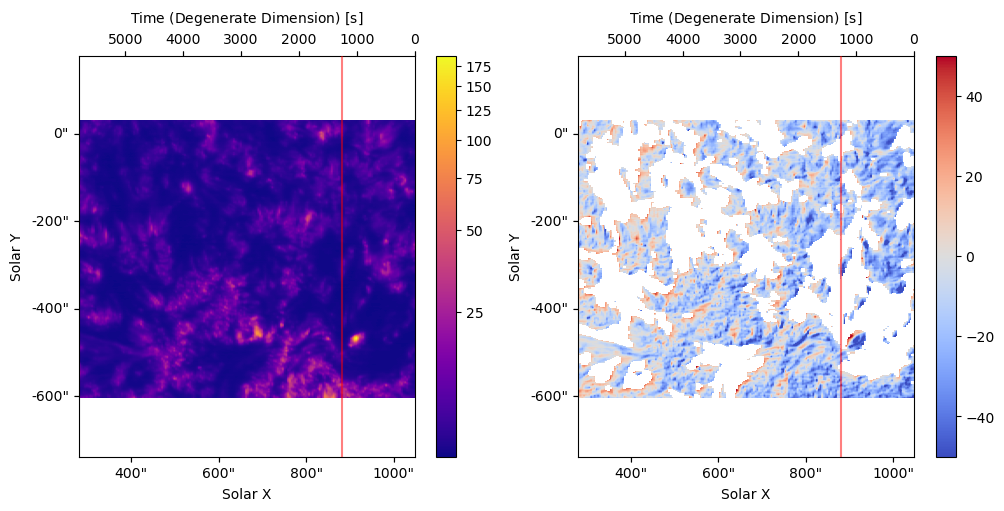

In [151]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=spice_CIII_window.wcs[0,0,:,:])
im1 = ax1.imshow(saffron_spice_CIII_int, origin='lower', cmap='plasma',
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar(im1)

ax2 = fig.add_subplot(122,projection=spice_CIII_window.wcs[0,0,:,:])
im2 = ax2.imshow(ma.masked_array(saffron_spice_CIII_vel, saffron_spice_CIII_int<2), origin='lower', cmap='coolwarm',
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=-50,vmax=50))
plt.colorbar(im2)

for ax in [ax1,ax2]:
    ax.set_xlabel('Solar X')
    ax.set_ylabel('Solar Y')
    ax.axvline(150, color='red', alpha=0.5)

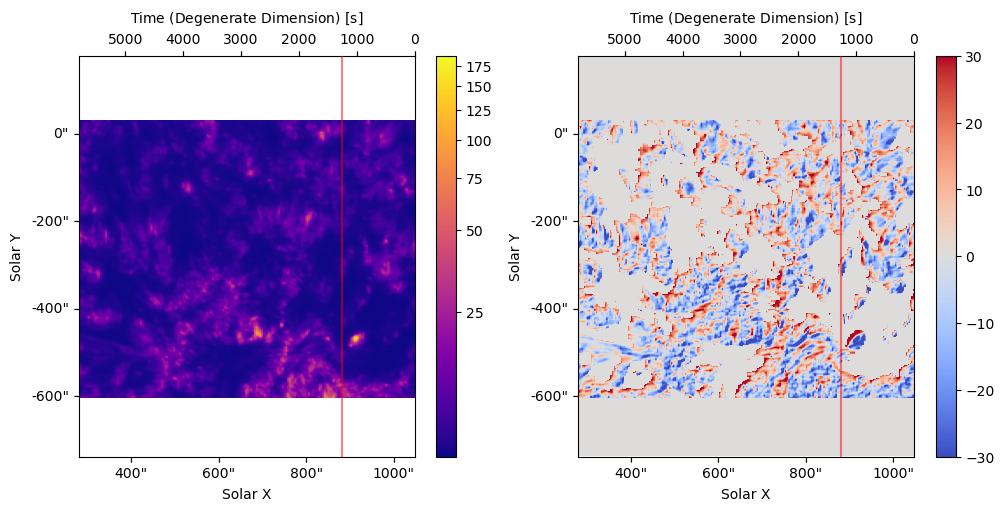

In [152]:
fig = plt.figure(figsize=(10,5),layout='constrained')
ax1 = fig.add_subplot(121,projection=spice_CIII_window.wcs[0,0,:,:])
im1 = ax1.imshow(saffron_spice_CIII_int, origin='lower', cmap='plasma',
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar(im1)

coolwarm_bad = plt.get_cmap('coolwarm')
coolwarm_bad.set_bad(coolwarm_bad(0.5))

ax2 = fig.add_subplot(122,projection=spice_CIII_window.wcs[0,0,:,:])
im2 = ax2.imshow(saffron_spice_CIII_vel_masked, origin='lower', cmap=coolwarm_bad,
          aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
          norm=ImageNormalize(vmin=-30,vmax=30))
plt.colorbar(im2)

for ax in [ax1,ax2]:
    ax.set_xlabel('Solar X')
    ax.set_ylabel('Solar Y')
    ax.axvline(150, color='red', alpha=0.5)

In [165]:
iris_spice_edge_pix_x, iris_spice_edge_pix_y = spice_CIII_window.wcs[0,0,:,:].world_to_pixel(*SiIV_1393_int_map_edges_with_time)
iris_spice_xslice = slice(np.round(np.nanmin(iris_spice_edge_pix_x)).astype(int), np.round(np.nanmax(iris_spice_edge_pix_x)).astype(int))
iris_spice_yslice = slice(np.round(np.nanmin(iris_spice_edge_pix_y)).astype(int), np.round(np.nanmax(iris_spice_edge_pix_y)).astype(int))

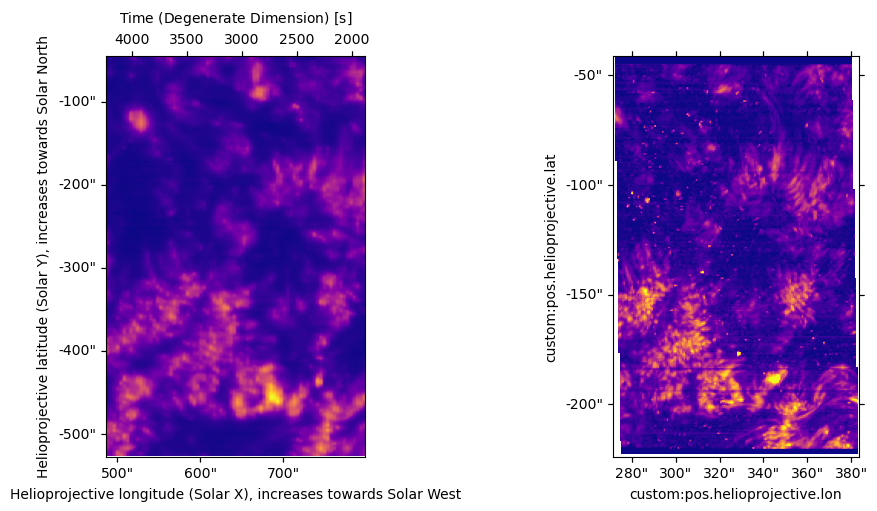

In [171]:
fig = plt.figure(figsize=(10,5),layout='constrained')

ax1 = fig.add_subplot(121,projection=spice_CIII_window.wcs[0,0,iris_spice_yslice,iris_spice_xslice])
ax1.imshow(saffron_spice_CIII_int[iris_spice_yslice,iris_spice_xslice], origin='lower', cmap='plasma',
           aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
           norm=ImageNormalize(stretch=AsinhStretch()))

ax2 = fig.add_subplot(122,projection=SiIV_1393_int_map)
ax2.imshow(SiIV_1393_int_map.data, origin='lower', cmap='plasma',
           aspect=SiIV_1393_int_map.meta['CDELT2']/SiIV_1393_int_map.meta['CDELT1'],
           norm=ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch()))

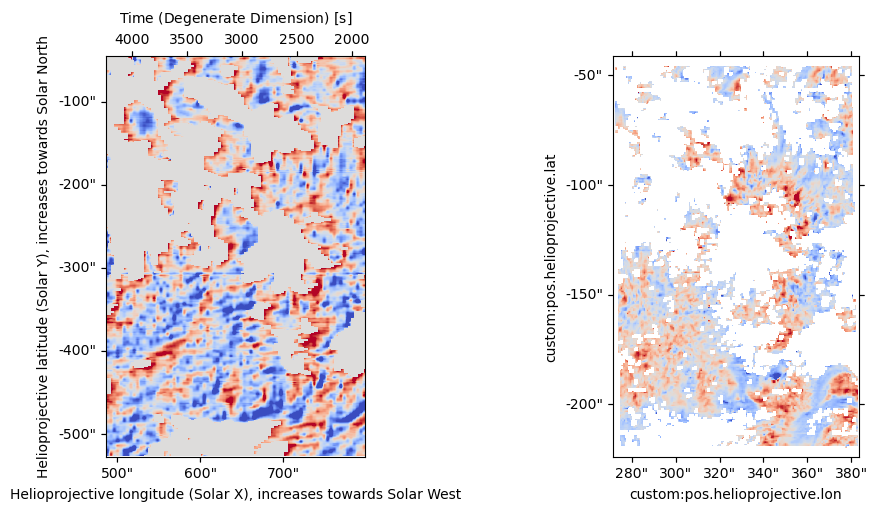

In [176]:
fig = plt.figure(figsize=(10,5),layout='constrained')

ax1 = fig.add_subplot(121,projection=spice_CIII_window.wcs[0,0,iris_spice_yslice,iris_spice_xslice])
ax1.imshow(saffron_spice_CIII_vel_masked[iris_spice_yslice,iris_spice_xslice] - \
           saffron_spice_CIII_vel_masked[iris_spice_yslice,iris_spice_xslice].mean(), origin='lower', cmap=coolwarm_bad,
              aspect=spice_CIII_window.meta['CDELT2']/spice_CIII_window.meta['CDELT1'],
              norm=ImageNormalize(vmin=-30,vmax=30))

ax2 = fig.add_subplot(122,projection=SiIV_1393_vel_map)
ax2.imshow(SiIV_1393_vel_map_norm.data, origin='lower', cmap='coolwarm',
           aspect=SiIV_1393_vel_map_norm.meta['CDELT2']/SiIV_1393_vel_map_norm.meta['CDELT1'],
           norm=ImageNormalize(vmin=-20,vmax=20))


In [177]:
spice_CIII_window.meta['exposure time']

<Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           3